<a href="https://colab.research.google.com/github/ghaiszaher/Foggy-CycleGAN/blob/master/Foggy_CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Foggy-CycleGAN

## Set up the input pipeline

In [1]:
import sys
colab = 'google.colab' in sys.modules
import tensorflow as tf

In [2]:
# noinspection PyUnresolvedReferences
print(tf.__version__)

2.17.0


In [3]:
import tensorflow_datasets as tfds

import os
from IPython.display import clear_output

tfds.disable_progress_bar()

In [4]:
if colab:
    os.environ['PROJECT_DIR'] = project_dir = '/content/Foggy-CycleGAN'
    replace = True
    if os.path.isdir(project_dir):
        choice = input("Project already exists in folder "+
              "{}\nDelete the files and pull again? Enter Y/(N):\n"
              .format(project_dir))
        if choice.lower()=='y':
            !rm -r $PROJECT_DIR
            print("Deleted folder {}".format(project_dir))
        else:
            replace = False
            print("Nothing was changed.")
    if replace:
        !cd /content && git clone https://github.com/ghaiszaher/Foggy-CycleGAN.git
        print("Project cloned to " + project_dir)
    os.chdir(project_dir)
    print("Done.")

## Prepare Datasets

In [5]:
BATCH_SIZE = 5 if colab else 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [6]:
project_label = "" #@param {type:"string"}

In [7]:
mount_path = None #to suppress warnings
drive_project_path = None
if colab:
    # noinspection PyUnresolvedReferences
    from google.colab import drive
    mount_path = '/content/drive'
    drive.mount(mount_path, force_remount=True)
    drive_project_path = os.path.join(mount_path,"My Drive/Colab Notebooks/Foggy-CycleGAN/",project_label)
    drive_datasets_path = os.path.join(mount_path,"My Drive/Colab Notebooks/Datasets/")
    os.environ['DRIVE_PROJECT'] = drive_project_path
    os.environ['DRIVE_DATASETS'] = drive_datasets_path

In [8]:
#Unzip dataset from Google Drive to /content/dataset/ folder
if colab:
    !sh $PROJECT_DIR/copy_dataset.sh

In [9]:
test_split = 0.2 #@param {type:"slider", min:0.05, max:0.95, step:0.05}

In [10]:
from lib.dataset import DatasetInitializer

datasetInit = DatasetInitializer(256, 256)
datasetInit.dataset_path = '/content/dataset/' if colab else  './dataset/'
(train_clear, train_fog), (test_clear, test_fog), (sample_clear, sample_fog) = datasetInit.prepare_dataset(
    BATCH_SIZE,
    test_split=test_split,
    random_seed=7)

Found 1566 clear images and 1703 fog images
Clear images split to 1253 train - 313 test
Fog images split to 1363 train - 340 test
Found 1 sample clear image(s) and 9 sample fog image(s)


## Build Generator

In [11]:
from lib.models import ModelsBuilder
OUTPUT_CHANNELS = 3
models_builder = ModelsBuilder()

In [12]:
use_transmission_map = False #@param{type: "boolean"}
use_gauss_filter = False #@param{type: "boolean"}
if use_gauss_filter and not use_transmission_map:
    raise Exception("Gauss filter requires transmission map")
use_resize_conv = True #@param{type: "boolean"}

generator_clear2fog = models_builder.build_generator(use_transmission_map=use_transmission_map,
                                                     use_gauss_filter=use_gauss_filter,
                                                     use_resize_conv=use_resize_conv)
generator_fog2clear = models_builder.build_generator(use_transmission_map=False)

In [13]:
tf.keras.utils.plot_model(generator_clear2fog, show_shapes=True, dpi=64, to_file='generator_clear2fog.png');

In [14]:
tf.keras.utils.plot_model(generator_fog2clear, show_shapes=True, dpi=64, to_file='generator_fog2clear.png');

## Build Discriminator

In [15]:
use_intensity_for_fog_discriminator = False #@param{type: "boolean"}
discriminator_fog = models_builder.build_discriminator(use_intensity=use_intensity_for_fog_discriminator)
discriminator_clear = models_builder.build_discriminator(use_intensity=False)

In [16]:
tf.keras.utils.plot_model(discriminator_fog, show_shapes=True, dpi=64, to_file="discriminator_fog.png");
tf.keras.utils.plot_model(discriminator_clear, show_shapes=True, dpi=64, to_file="discriminator_clear.png");

## Checkpoints

In [17]:
if colab:
    weights_path = os.path.join(drive_project_path, 'weights/')
else:
    weights_path = "./weights/2024-11-17-rev4-001"

In [18]:
from lib.train import Trainer
trainer = Trainer(generator_clear2fog, generator_fog2clear,
                 discriminator_fog, discriminator_clear)

trainer.configure_checkpoint(weights_path = weights_path, load_optimizers=False)

Weights loaded: ./weights/2024-11-17-rev4-001/generator_clear2fog.weights.h5
Weights loaded: ./weights/2024-11-17-rev4-001/generator_fog2clear.weights.h5
Weights loaded: ./weights/2024-11-17-rev4-001/discriminator_clear.weights.h5
Weights loaded: ./weights/2024-11-17-rev4-001/discriminator_fog.weights.h5


2024-11-18 23:07:39.622521: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-11-18 23:07:39.622857: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-11-18 23:07:39.880611: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence

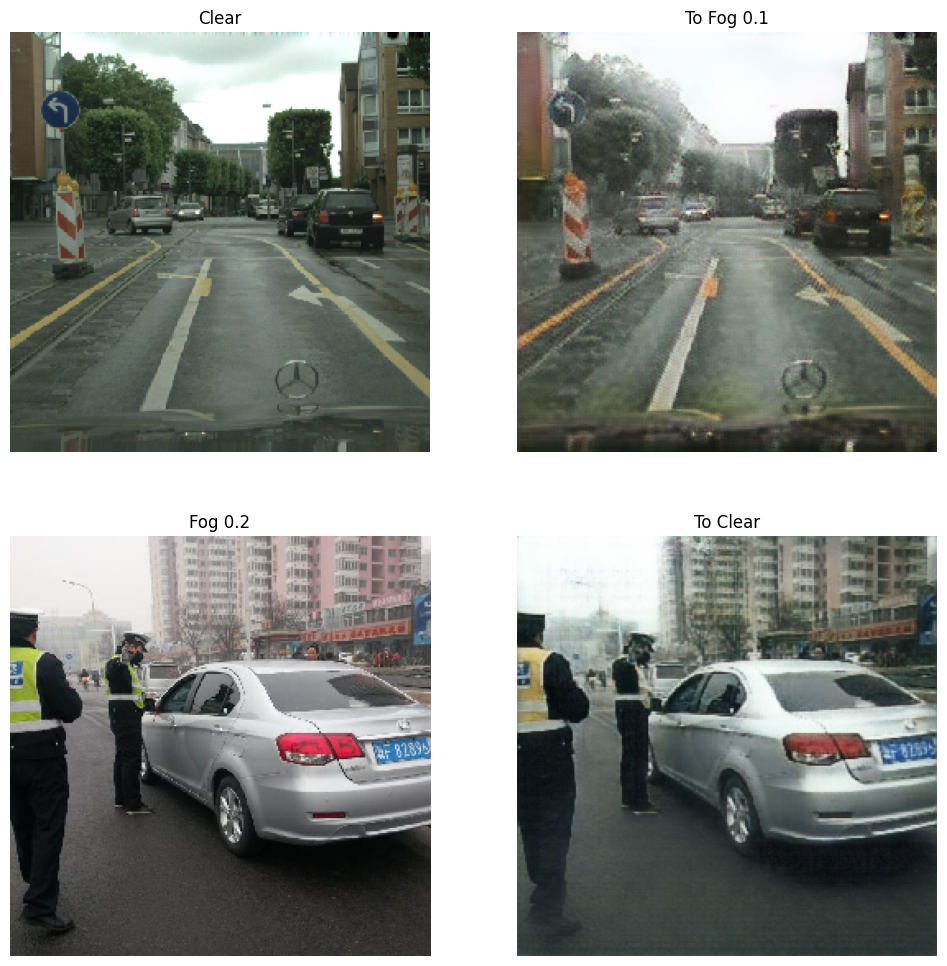

In [19]:
from lib.plot import plot_generators_predictions
for clear, fog in tf.data.Dataset.zip((sample_clear.take(1), sample_fog.take(1))):
    plot_generators_predictions(generator_clear2fog, clear, generator_fog2clear, fog)

2024-11-18 23:07:40.553155: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-11-18 23:07:40.554282: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-11-18 23:07:40.693278: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence

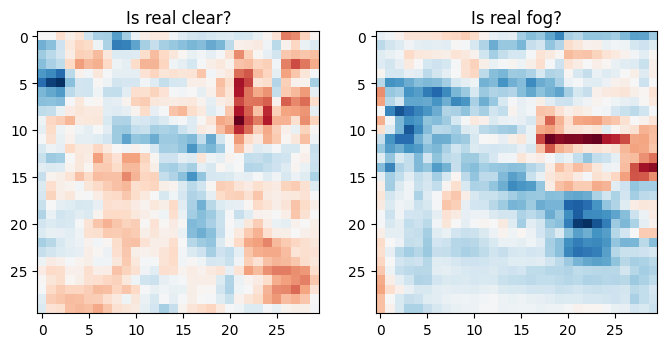

In [20]:
from lib.plot import plot_discriminators_predictions
for clear, fog in tf.data.Dataset.zip((sample_clear.take(1), sample_fog.take(1))):
    plot_discriminators_predictions(discriminator_clear, clear, discriminator_fog, fog, use_intensity_for_fog_discriminator)

## Training

In [21]:
use_tensorboard = True #@param{type:"boolean"}

In [22]:
if use_tensorboard:
    import tensorboard
    tb = tensorboard.program.TensorBoard()
    if colab:
        trainer.tensorboard_base_logdir = os.path.join(drive_project_path,"tensorboard_logs/")
    tb.configure(argv=[None, '--logdir', trainer.tensorboard_base_logdir])
    url = tb.launch()
    if colab:
        tensorboard.notebook.display(port=6006, height=1000)
    else:
        print(url)

/Users/ghaiszaher/Library/Caches/pypoetry/virtualenvs/foggy-cyclegan-8iyj8dkp-py3.12/lib/python3.12/site-packages/tensorboard/_vendor/bleach/sanitizer.py:292: SyntaxWarning: invalid escape sequence '\s'
  "[`\000-\040\177-\240\s]+",
/Users/ghaiszaher/Library/Caches/pypoetry/virtualenvs/foggy-cyclegan-8iyj8dkp-py3.12/lib/python3.12/site-packages/tensorboard/_vendor/bleach/sanitizer.py:339: SyntaxWarning: invalid escape sequence '\s'
  style = re.compile('url\s*\(\s*[^\s)]+?\s*\)\s*').sub(' ', style)
/Users/ghaiszaher/Library/Caches/pypoetry/virtualenvs/foggy-cyclegan-8iyj8dkp-py3.12/lib/python3.12/site-packages/tensorboard/_vendor/bleach/sanitizer.py:354: SyntaxWarning: invalid escape sequence '\s'
  if not re.match("^\s*([-\w]+\s*:[^:;]*(;\s*|$))*$", style):
/Users/ghaiszaher/Library/Caches/pypoetry/virtualenvs/foggy-cyclegan-8iyj8dkp-py3.12/lib/python3.12/site-packages/tensorboard/_vendor/bleach/sanitizer.py:358: SyntaxWarning: invalid escape sequence '\w'
  for prop, value in re.find

http://localhost:6006/


In [23]:
if colab:
    trainer.image_log_path = os.path.join(drive_project_path,"image_logs/")
    trainer.config_path  = os.path.join(drive_project_path,"trainer_config.json")

In [24]:
trainer.load_config()

Config path doesn't exist. Ignoring load config.


## Testing Custom images


In [25]:
from lib.plot import plot_clear2fog_intensity
from matplotlib import pyplot as plt

# split weights_path and take the last part and add it to intensity_path
intensity_path = './intensity/'
from lib.tools import create_dir
create_dir(intensity_path)

downloads_path = './downloads/'
folder_path = os.path.join(intensity_path, weights_path.split('/')[-1])
create_dir(folder_path)

for file_name in os.listdir(downloads_path):
    if not file_name.endswith('.png'):
        continue
    file_folder_path = os.path.join(folder_path, os.path.splitext(file_name)[0])
    print("Creating folder: ", file_folder_path)
    create_dir(file_folder_path)
    print("Processing file: ", file_name)
    file_path = os.path.join(downloads_path, file_name)

    image_clear = tf.io.decode_png(tf.io.read_file(file_path), channels=3)
    image_clear, _ = datasetInit.preprocess_image_test(image_clear, 0)
    step = 0.05
    for (ind, i) in enumerate(tf.range(0,1+step, step)):
        fig = plot_clear2fog_intensity(generator_clear2fog, image_clear, i)
        fig.savefig(os.path.join(file_folder_path
                                 , "{:02d}_intensity_{:0.2f}.jpg".format(ind,i)), bbox_inches='tight', pad_inches=0)
        if colab:
            plt.show()
        else:
            plt.close(fig)
    print("Done with file: ", file_name)

Creating folder:  ./intensity/2024-11-17-rev4-001/sample10
Processing file:  sample10.png
Done with file:  sample10.png
Creating folder:  ./intensity/2024-11-17-rev4-001/sample11
Processing file:  sample11.png
Done with file:  sample11.png
Creating folder:  ./intensity/2024-11-17-rev4-001/sample9
Processing file:  sample9.png
Done with file:  sample9.png
Creating folder:  ./intensity/2024-11-17-rev4-001/sample8
Processing file:  sample8.png
Done with file:  sample8.png
Creating folder:  ./intensity/2024-11-17-rev4-001/sample6
Processing file:  sample6.png
Done with file:  sample6.png
Creating folder:  ./intensity/2024-11-17-rev4-001/sample7
Processing file:  sample7.png
Done with file:  sample7.png
Creating folder:  ./intensity/2024-11-17-rev4-001/sample5
Processing file:  sample5.png
Done with file:  sample5.png
Creating folder:  ./intensity/2024-11-17-rev4-001/sample4
Processing file:  sample4.png
Done with file:  sample4.png
Creating folder:  ./intensity/2024-11-17-rev4-001/sample1


In [26]:
if colab:
    !cd ./intensity; zip /content/intensity.zip *